# SASCO customer segmentation

In [1]:
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#initiate visualization library for jupyter notebook 
pyoff.init_notebook_mode()

## Import data

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
retaildf = pd.read_csv('sasco_OnlineRetail.csv', parse_dates=['InvoiceDate'], date_parser=dateparse, encoding = 'unicode_escape')
print("Number of lines:" + str(len(retaildf)))
retaildf.head(10)

Number of lines:541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2018-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2018-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2018-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2018-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2018-12-01 08:34:00,1.69,13047.0,United Kingdom


### Null analysis

In [5]:
retaildf.isnull().sum()
# When CustomerID is null, well we can't use it for the customer segmentation. We can drop it / ignore it.
# If Description is null, it can still be useful for our segmentation.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
retaildf.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
retaildf['InvoiceDate'] = pd.to_datetime(retaildf['InvoiceDate'])
retaildf['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2019-10-31 14:41:00
freq                     1114
first     2018-12-01 08:26:00
last      2019-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [8]:
#only retail UK will be used for analysis
retaildf_uk = retaildf[retaildf.Country == 'United Kingdom'].reset_index(drop=True)

In [9]:
retaildf_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
retaildf_user = pd.DataFrame(retaildf['CustomerID'].unique())
retaildf_user.columns = ['CustomerID']

In [11]:
retaildf_user

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
...,...
4368,13436.0
4369,15520.0
4370,13298.0
4371,14569.0


# Recency

In [12]:
## To calculate recency, we need to find out most recent purchase date of each customer and 
# see how many days they are inactive for. After having no. of inactive days for each customer,
# we will apply K-means* clustering to assign customers a recency score.

In [13]:
retaildf_max_purchase = retaildf_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
retaildf_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [14]:
retaildf_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2019-01-18 10:17:00
1,12747.0,2019-12-07 14:34:00
2,12748.0,2019-12-09 12:20:00
3,12749.0,2019-12-06 09:56:00
4,12820.0,2019-12-06 15:12:00


In [15]:
retaildf_max_purchase['Recency'] = (retaildf_max_purchase['MaxPurchaseDate'].max() - retaildf_max_purchase['MaxPurchaseDate']).dt.days
retaildf_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2019-01-18 10:17:00,325
1,12747.0,2019-12-07 14:34:00,1
2,12748.0,2019-12-09 12:20:00,0
3,12749.0,2019-12-06 09:56:00,3
4,12820.0,2019-12-06 15:12:00,2


In [16]:
retaildf_user = pd.merge(retaildf_user, retaildf_max_purchase[['CustomerID','Recency']], on='CustomerID')
retaildf_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [17]:
retaildf_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

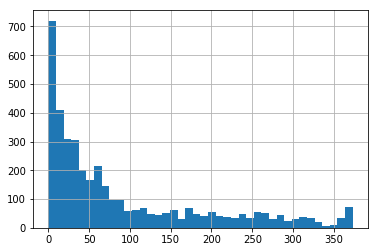

In [18]:
retaildf_user.Recency.hist(bins=40)

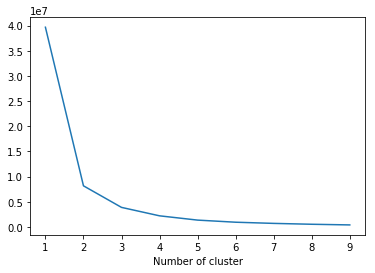

In [19]:
#Using elbow method
from sklearn.cluster import KMeans

sse={}
tx_recency = retaildf_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7391784676501351


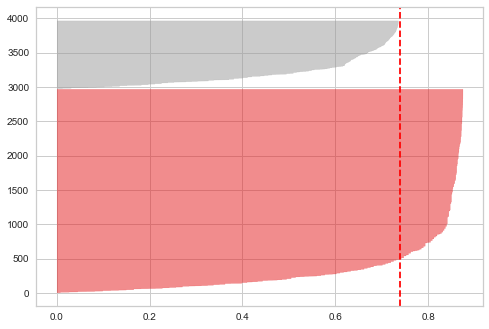

For n_clusters = 3 The average silhouette_score is : 0.6789933685765407


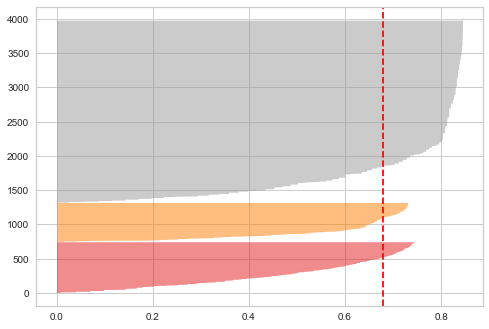

For n_clusters = 4 The average silhouette_score is : 0.6204325708893099


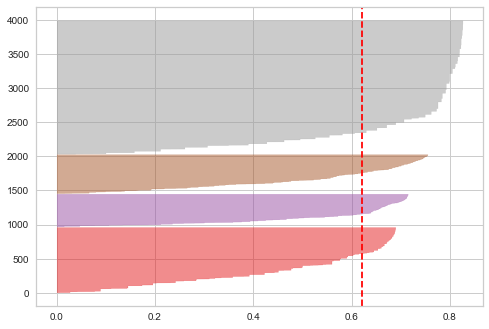

For n_clusters = 5 The average silhouette_score is : 0.6178096064956214


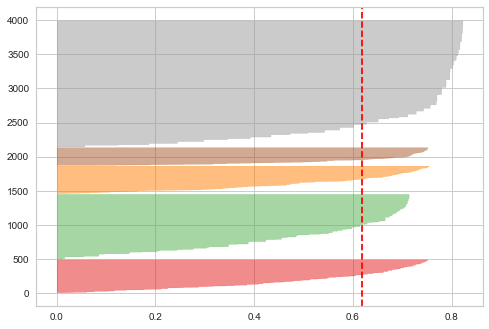

For n_clusters = 6 The average silhouette_score is : 0.6072521527089729


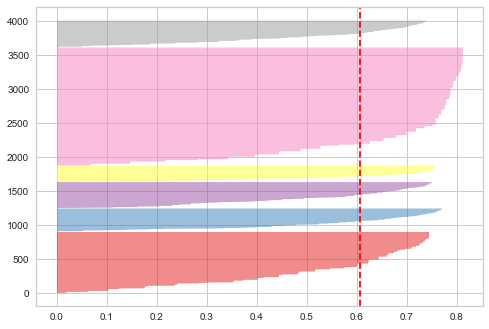

In [20]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm

#Using silhouettes
def plot_silhouettes(X, range_n_clusters):
  for n_clusters in range_n_clusters:
      clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      cluster_labels = clusterer.fit_predict(X)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
      visualizer = SilhouetteVisualizer(clusterer)
      visualizer.fit(X)        # Fit the data to the visualizer
      plt.show()

tx_recency = retaildf_user[['Recency']]
range_n_clusters = [2, 3, 4, 5, 6]
plot_silhouettes(tx_recency, range_n_clusters)

In [21]:
#Here it looks like 3 is the optimal one. Based on business requirements, 
# we can go ahead with less or more clusters. We will be selecting 4 clusters.

In [22]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(retaildf_user[['Recency']])
retaildf_user['RecencyCluster'] = kmeans.predict(retaildf_user[['Recency']])

In [23]:
retaildf_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0


In [24]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
retaildf_user = order_cluster('RecencyCluster', 'Recency',retaildf_user,False)

In [25]:
print(retaildf_user.head())
print(retaildf_user.tail())

   CustomerID  Recency  RecencyCluster
0     17850.0      301               0
1     15100.0      329               0
2     18074.0      373               0
3     16250.0      260               0
4     13747.0      373               0
      CustomerID  Recency  RecencyCluster
3945     15942.0      133               1
3946     14143.0      133               1
3947     16147.0      133               1
3948     15149.0      133               1
3949     15776.0      132               1


In [26]:
retaildf_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


In [27]:
# Cluster no 3 covers most recent customers whereas cluster no 0 has the most inactive ones

## Frequency

In [28]:
# To create frequency clusters, we need to find total number orders for each customer

In [29]:
retaildf_frequency = retaildf_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
retaildf_frequency.columns = ['CustomerID', 'Frequency']
retaildf_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [30]:
retaildf_user = pd.merge(retaildf_user, retaildf_frequency, on='CustomerID')

In [31]:
print(retaildf_user.head())

   CustomerID  Recency  RecencyCluster  Frequency
0     17850.0      301               0        312
1     15100.0      329               0          6
2     18074.0      373               0         13
3     16250.0      260               0         24
4     13747.0      373               0          1


In [32]:
retaildf_user.Frequency.describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

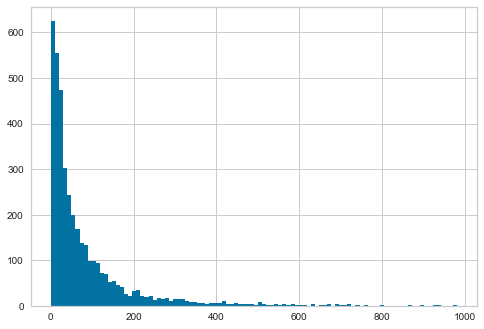

In [33]:
retaildf_user.Frequency[retaildf_user.Frequency < 1000].hist(bins=100)

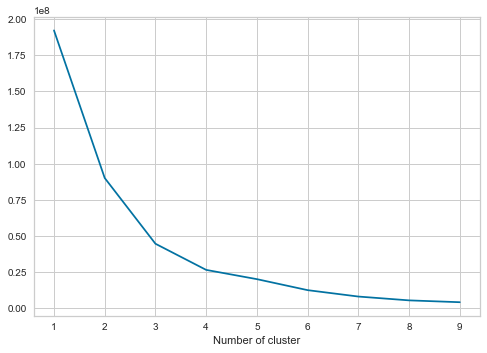

In [34]:
#Using elbow method
sse={}
tx_frequency = retaildf_user[['Frequency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(retaildf_user[['Frequency']])
retaildf_user['FrequencyCluster'] = kmeans.predict(retaildf_user[['Frequency']])

#see details of each cluster
retaildf_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
3,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0


In [36]:
print(retaildf_user.head())
print(retaildf_user.tail())

   CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0     17850.0      301               0        312                 2
1     15100.0      329               0          6                 0
2     18074.0      373               0         13                 0
3     16250.0      260               0         24                 0
4     13747.0      373               0          1                 0
      CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
3945     15942.0      133               1         14                 0
3946     14143.0      133               1          7                 0
3947     16147.0      133               1         22                 0
3948     15149.0      133               1         23                 0
3949     15776.0      132               1         18                 0


In [37]:
#order the frequency cluster
retaildf_user = order_cluster('FrequencyCluster', 'Frequency',retaildf_user,True)
#see details of each cluster
retaildf_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


In [38]:
#As the same notation as recency clusters, 
#high frequency number indicates better customers

## Monetary Value

In [39]:
# to see how our customer database looks like when we cluster them based on revenue.
# calculate revenue for each customer, plot a histogram and apply the same clustering method

In [40]:
#calculate revenue for each customer
retaildf_uk['Revenue'] = retaildf_uk['UnitPrice'] * retaildf_uk['Quantity']
retaildf_revenue = retaildf_uk.groupby('CustomerID').Revenue.sum().reset_index()
retaildf_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [41]:
retaildf_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1


In [46]:
#merge it with our main dataframe
retaildf_user = pd.merge(retaildf_user, retaildf_revenue, on='CustomerID')

In [47]:
print(retaildf_user.head())

   CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue
0     17850.0      301               0        312                 1   5288.63
1     15808.0      305               0        210                 1   3724.77
2     13047.0       31               3        196                 1   3079.10
3     14688.0        7               3        359                 1   5107.38
4     16029.0       38               3        274                 1  50992.61


In [48]:
retaildf_user.Revenue.describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

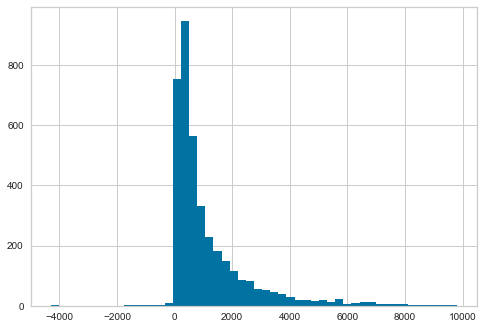

In [50]:
retaildf_user.Revenue[retaildf_user.Revenue < 10000].hist(bins=50)

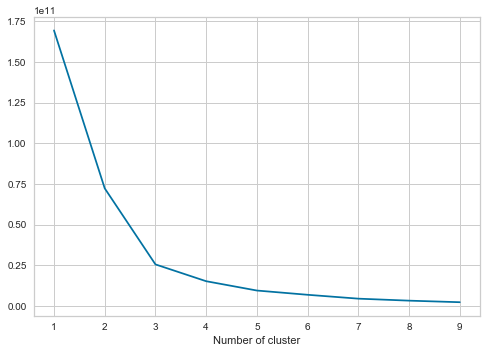

In [51]:
#Using elbow method
sse={}
tx_revenue = retaildf_user[['Revenue']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [52]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(retaildf_user[['Revenue']])
retaildf_user['RevenueCluster'] = kmeans.predict(retaildf_user[['Revenue']])

#order the cluster numbers
retaildf_user = order_cluster('RevenueCluster', 'Revenue',retaildf_user,True)

#show details of the dataframe
retaildf_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


## Overall score

In [53]:
retaildf_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [75]:
export_csv = retaildf_user.to_csv (r'sasco_clean.csv', index = None, header=True)

In [54]:
#calculate overall score based on total cluster number assigned for each customerID
retaildf_user['OverallScore'] = retaildf_user['RecencyCluster'] + retaildf_user['FrequencyCluster'] + retaildf_user['RevenueCluster']

In [55]:
retaildf_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5


In [56]:
#use mean() to see details
retaildf_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [59]:
retaildf_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     474
1     562
2     920
3    1511
4     298
5     148
6      27
7       7
8       3
Name: Recency, dtype: int64

In [ ]:
#The scoring above shows that customers with score 8 is 
# our best customers whereas 0 is the worst.

In [ ]:
#To keep things simple, better we name these scores:
# 0 to 2: Low Value
# 3 to 4: Mid Value
# 5+: High Value

In [60]:
retaildf_user['Segment'] = 'Low-Value'
retaildf_user.loc[retaildf_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
retaildf_user.loc[retaildf_user['OverallScore']>4,'Segment'] = 'High-Value'

In [292]:
retaildf_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [72]:
print(retaildf_user.head())

   CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  OverallScore     Segment  
0               1             2   Low-Value  
1               1             5  High-Value  
2               1             5  High-Value  
3               1             5  High-Value  
4               1             5  High-Value  


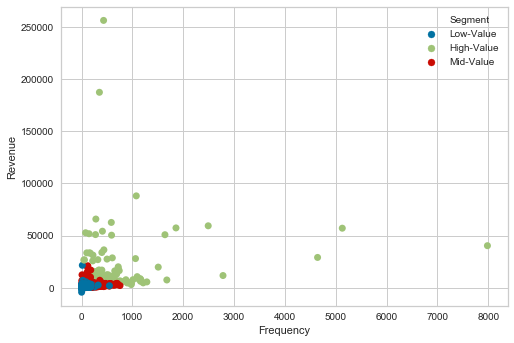

In [98]:
tx_graph = retaildf_user.query("Revenue <300000 and Frequency <8000")
sns.scatterplot(x='Frequency', y='Revenue', data=tx_graph, hue='Segment', linewidth=0)

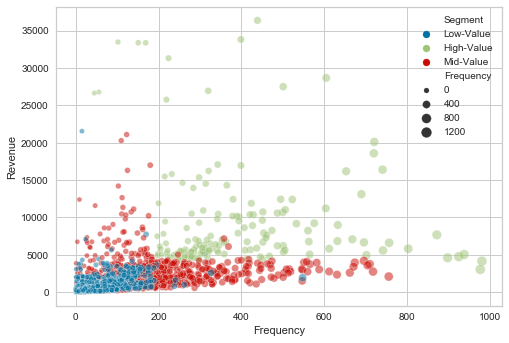

In [153]:
#squeeze the plot by excluding outlier for high-value
# PLOT for REVENUE vs FREQUENCY
tx_graph1 = retaildf_user.query("Revenue <50000 and Revenue >0 and Frequency <1000")
sns.scatterplot(x='Frequency', y='Revenue', data=tx_graph1, hue='Segment', linewidth=0.5, alpha=.5, marker='o',size='Frequency')

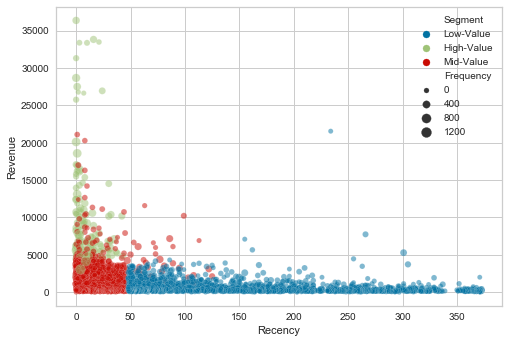

In [145]:
# PLOT for REVENUE vs RECENCY
sns.scatterplot(x='Recency', y='Revenue', data=tx_graph1, hue='Segment', linewidth=0.2, alpha=.5,size='Frequency')

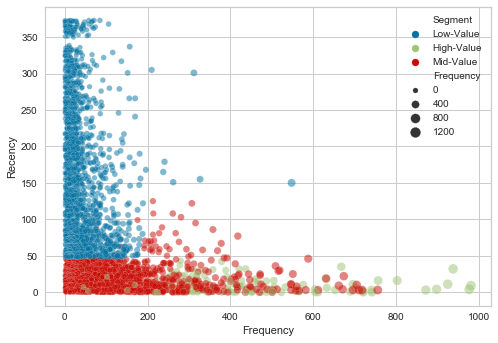

In [160]:
# PLOT for RECENCY vs FREQUENCY
sns.scatterplot(x='Frequency', y='Recency', data=tx_graph1, hue='Segment',linewidth=0.2, alpha=.5,size = 'Frequency')

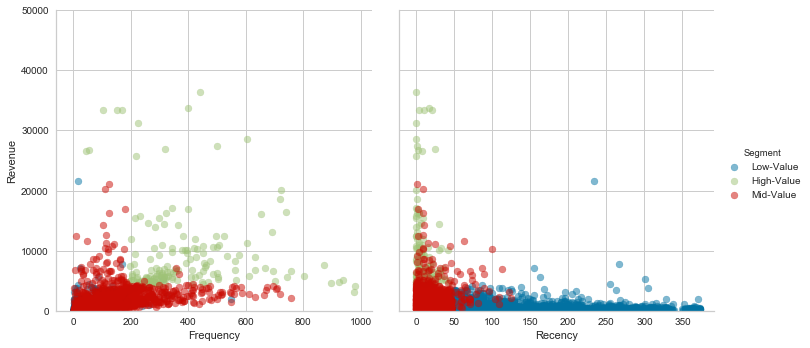

In [166]:
g = sns.PairGrid(tx_graph1, y_vars=["Revenue"], x_vars=["Frequency", "Recency"], height =5,hue="Segment")
g.map(plt.scatter,alpha=.5)
g.set(ylim=(0, 50000), yticks=[0,10000,20000,30000,40000,50000])
g.add_legend()

## INSIGHTS !

We can start taking actions with this segmentation. The main strategies are quite clear:
- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency

_Note:
Ideally, what we do here can be easily achieved by using quantiles or simple binning (or Jenks natural breaks optimization to make groups more accurate) but we are using k-means to get familiar with it._

## References
[1] https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444? 

[2] https://www.kaggle.com/roborz/utt-partie-3

In [287]:
retaildf_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [288]:
segment=retaildf_user.groupby('Segment').CustomerID.count().reset_index()
segment

,Segment,CustomerID
0,High-Value,185
1,Low-Value,1956
2,Mid-Value,1809


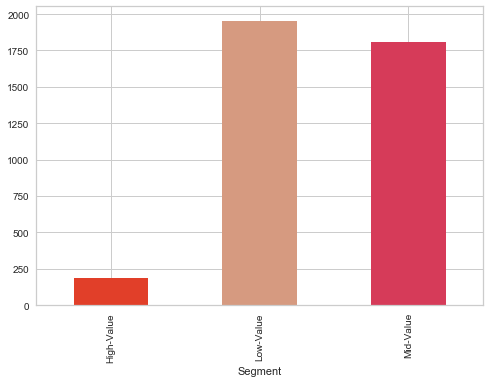

In [291]:
colors = ["#E13F29", "#D69A80", "#D63B59"]
segment.plot.bar(x='Segment',y='CustomerID',legend=0,color=colors,)

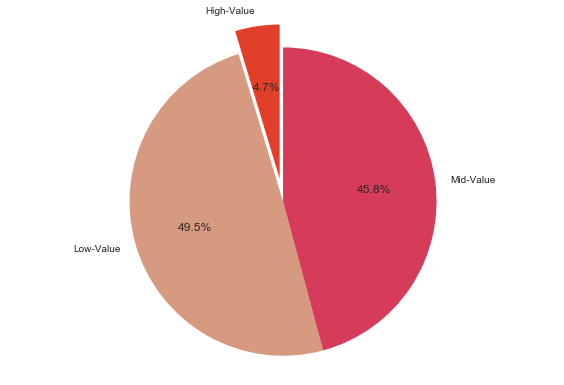

In [208]:
# Create a list of colors (from iWantHue)
colors = ["#E13F29", "#D69A80", "#D63B59"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    segment['CustomerID'],
    # with the labels being officer names
    labels=segment['Segment'],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with one slide exploded out
    explode=(0.15, 0, 0),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

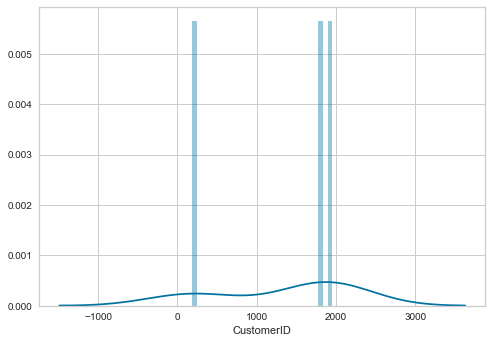

In [252]:
sns.distplot(segment['CustomerID'],bins=30,rug=False, norm_hist =1)

In [272]:
segment.dtypes

Segment       int64
CustomerID    int64
dtype: object

In [285]:
segment.Segment.density()

AttributeError: 'Series' object has no attribute 'density'